In [1]:
import contextlib
import dataclasses
import datetime
import logging
import multiprocessing
import os
from pathlib import Path

import corner
import emcee
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from scipy import optimize, stats

from bayesian_analysis import FitConfig
from cr_knee_fit import experiments
from cr_knee_fit.cr_model import (
    CosmicRaysModel,
    CosmicRaysModelConfig,
    RigidityBreak,
    SharedPowerLaw,
)
from cr_knee_fit.experiments import Experiment
from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import loglikelihood, logposterior, set_global_fit_data
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.plotting import plot_credible_band
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts
from cr_knee_fit.types_ import Primary
from cr_knee_fit.utils import add_log_margin

In [2]:
FIT_DIR = Path("out/composition")
fc = FitConfig.model_validate_json((FIT_DIR / "config.json").read_text())
theta_sample = np.loadtxt(FIT_DIR / "theta.txt")

# p / He ratio


In [3]:
R_BOUNDS = (7e2, 1e6)

In [4]:
@dataclasses.dataclass
class pHeRatioData:
    R: np.ndarray  # GV

    ratio: np.ndarray  # dimensionless
    ratio_errlo: np.ndarray
    ratio_errhi: np.ndarray

    experiment: Experiment


nucleon = Experiment("NUCLEON")
experiments = [experiments.ams02, experiments.calet, nucleon]
data: list[pHeRatioData] = []
for exp in experiments:
    path = f"data/output/{exp.filename_stem_}_p_He_ratio_rigidity.txt"

    cols = (0, 1, 2, 3, 4, 5)
    R, value, err_sta_lo, err_sta_up, err_sys_lo, err_sys_up = np.loadtxt(
        path, usecols=cols, unpack=True
    )
    mask = np.logical_and(R >= R_BOUNDS[0], R <= R_BOUNDS[1])
    data.append(
        pHeRatioData(
            R=R[mask],
            ratio=value[mask],
            ratio_errhi=np.sqrt(err_sta_up[mask] ** 2 + err_sys_up[mask] ** 2),
            ratio_errlo=np.sqrt(err_sta_lo[mask] ** 2 + err_sys_lo[mask] ** 2),
            experiment=exp,
        )
    )

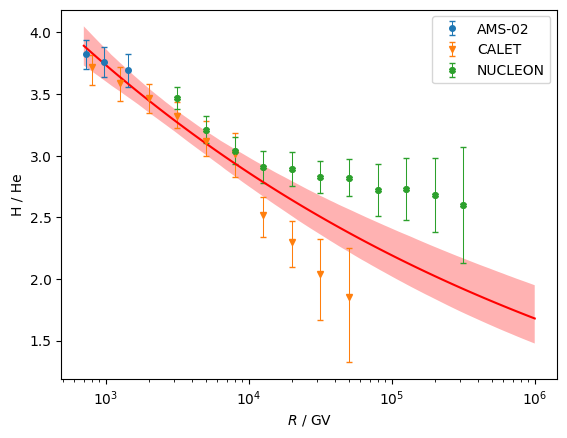

In [5]:
fig, ax = plt.subplots()


def H_He_ratio(model: Model, R: np.ndarray) -> np.ndarray:
    return model.cr_model.compute_rigidity(R, Primary.H) / model.cr_model.compute_rigidity(
        R, Primary.He
    )


for d in data:
    ax.errorbar(
        x=d.R,
        y=d.ratio,
        yerr=(d.ratio_errlo, d.ratio_errhi),
        label=d.experiment.name,
        markersize=4.0,
        elinewidth=0.75,
        capsize=2.0,
        fmt=d.experiment.marker,
    )

plot_credible_band(
    ax,
    scale=0,
    bounds=R_BOUNDS,
    observable=H_He_ratio,
    color="red",
    theta_sample=theta_sample,
    model_config=fc.model,
    add_median=True,
)
ax.set_xlabel("$ R $ / $ \\text{GV} $")
ax.set_xscale("log")
ax.set_ylabel("H / He")
# ax.set_yscale("log")
ax.legend()

# p + He (light group)


In [6]:
from cr_knee_fit import experiments
from model.utils import load_data


@dataclasses.dataclass
class LightGroupData:
    E: np.ndarray  # GeV

    F: np.ndarray  # (GeV m^2 s sr)^-1
    F_errlo: np.ndarray
    F_errhi: np.ndarray

    experiment: Experiment


exps = [experiments.cream, experiments.dampe, Experiment("TIBET")]
light_group_data: list[LightGroupData] = []
for exp in exps:
    raw = load_data(
        filename=f"{exp.filename_stem_}_light_energy.txt",
        slope=0,
        norm=1.0,
        min_energy=1e3,
        max_energy=1e6,
    )
    light_group_data.append(
        LightGroupData(
            E=raw[0],
            F=raw[1],
            F_errlo=raw[2],
            F_errhi=raw[3],
            experiment=exp,
        )
    )

Text(0.5, 1.0, 'H + He (light group)')

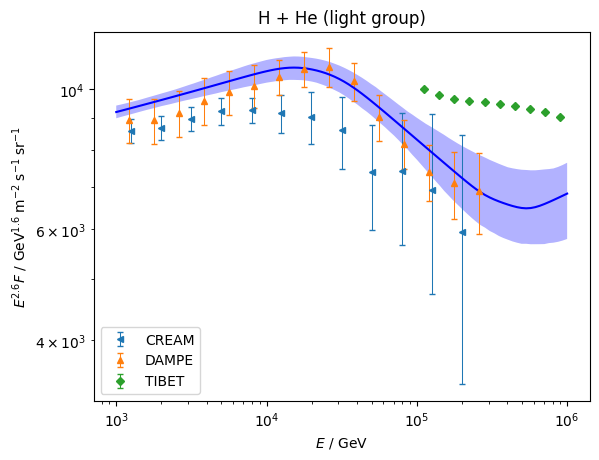

In [7]:
from cr_knee_fit.utils import label_energy_flux

fig, ax = plt.subplots()
scale = 2.6

for d in light_group_data:
    E_factor = d.E**scale
    ax.errorbar(
        x=d.E,
        y=E_factor * d.F,
        yerr=(E_factor * d.F_errlo, E_factor * d.F_errhi),
        label=d.experiment.name,
        markersize=4.0,
        elinewidth=0.75,
        capsize=2.0,
        fmt=d.experiment.marker,
    )

plot_credible_band(
    ax,
    scale=scale,
    bounds=(1e3, 1e6),
    observable=lambda model, E: (
        model.cr_model.compute(E, primary=Primary.H) + model.cr_model.compute(E, primary=Primary.He)
    ),
    color="blue",
    theta_sample=theta_sample,
    model_config=fc.model,
    add_median=True,
)
label_energy_flux(ax, scale=scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_title("H + He (light group)")

Text(0.5, 1.0, 'All particle')

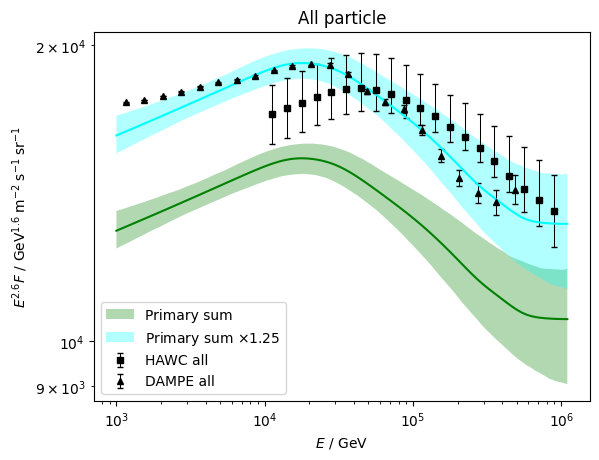

In [9]:
from cr_knee_fit.fit_data import CRSpectrumData
from cr_knee_fit.utils import label_energy_flux

fig, ax = plt.subplots()
scale = 2.6

for exp, max_energy in ((experiments.hawc, None), (experiments.dampe, 6e5)):
    d = CRSpectrumData.load_all_particle(exp, max_energy=max_energy)
    d.plot(scale, ax=ax)

for factor, label, color in ((1.0, "Primary sum", "green"), (1.25, "Primary sum $\\times 1.25$", "cyan")):
    plot_credible_band(
        ax,
        scale=scale,
        bounds=(1e3, 1.1e6),
        observable=lambda model, E: (
            np.array(sum(model.cr_model.compute(E, primary=p) for p in Primary)) * factor
        ),
        color=color,
        theta_sample=theta_sample,
        model_config=fc.model,
        add_median=True,
        label=label,
    )
label_energy_flux(ax, scale=scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_title("All particle")